In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import torchvision
import torch.optim as optim

import numpy as np

from models import models
from sklearn.manifold import TSNE

import argparse, sys, os

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.nn.init as init
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import time
from collections import Counter
import matplotlib.pyplot as plt 

In [2]:
data2 = np.load(r'C:\Users\dingk\Desktop\experiment\DL-model with MMD\ExtractedFeatures\3session012\session2.npy')
label2 = np.load(r'C:\Users\dingk\Desktop\experiment\DL-model with MMD\ExtractedFeatures\3session012\label2.npy')
data1 = np.load(r'C:\Users\dingk\Desktop\experiment\DL-model with MMD\ExtractedFeatures\3session012\session1.npy')
label1 = np.load(r'C:\Users\dingk\Desktop\experiment\DL-model with MMD\ExtractedFeatures\3session012\label1.npy')
data3 = np.load(r'C:\Users\dingk\Desktop\experiment\DL-model with MMD\ExtractedFeatures\3session012\session3.npy')
label3 = np.load(r'C:\Users\dingk\Desktop\experiment\DL-model with MMD\ExtractedFeatures\3session012\label3.npy')

print(data2.shape,label2.shape)
print(data1.shape,label1.shape)

print(Counter(label1))

train_data = np.concatenate((data1,data3),axis = 0)
label_data = np.concatenate((label1,label3),axis = 0)

test = data2
label_test = label2
print(train_data.shape,label_data.shape)

(23758, 62, 5) (23758,)
(23758, 62, 5) (23758,)
Counter({1: 8190, 2: 7840, 0: 7728})
(47516, 62, 5) (47516,)


In [3]:
def get_train_loader(data,label,batch_size,shuffle=True):
    """
    Get train dataloader of source domain or target domain
    :return: dataloader
    """
    tensor_x = torch.Tensor(data) # transform to torch tensor
    tensor_y = torch.Tensor(label)

    my_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
    my_dataloader = torch.utils.data.DataLoader(my_dataset,batch_size=batch_size,shuffle=True,drop_last=True,
                                               num_workers=8, pin_memory=True) # create your dataloader
    
    return my_dataloader

def get_test_loader(data,label,batch_size,shuffle=True):
    """
    Get test dataloader of source domain or target domain
    :return: dataloader
    """
    tensor_x = torch.Tensor(data) # transform to torch tensor
    tensor_y = torch.Tensor(label)

    my_dataset = torch.utils.data.TensorDataset(tensor_x,tensor_y) # create your datset
    my_dataloader = torch.utils.data.DataLoader(my_dataset,batch_size=batch_size,shuffle=True,drop_last=True,
                                               num_workers=8, pin_memory=True) # create your dataloader
    
    return my_dataloader


def optimizer_scheduler(optimizer, p):
    """
    Adjust the learning rate of optimizer
    :param optimizer: optimizer for updating parameters
    :param p: a variable for adjusting learning rate
    :return: optimizer
    """
    for param_group in optimizer.param_groups:
        param_group['lr'] = 0.01 / (1. + 10 * p) ** 0.75

    return optimizer

In [4]:
class GradReverse(torch.autograd.Function):
    """
    Extension of grad reverse layer
    """
    @staticmethod
    def forward(ctx, x, constant):
        ctx.constant = constant
        return x.view_as(x)

    @staticmethod
    def backward(ctx, grad_output):
        grad_output = grad_output.neg() * ctx.constant
        return grad_output, None

    def grad_reverse(x, constant):
        return GradReverse.apply(x, constant)

class Extractor(nn.Module):

    def __init__(self):
        super(Extractor, self).__init__()
        self.conv1 = nn.Conv1d(5, 64, 5, 1) 
        self.bn1 = nn.BatchNorm1d(64)
        self.conv2 = nn.Conv1d(64, 64, 5, 1) 
        self.bn2 = nn.BatchNorm1d(64)
        self.conv3 = nn.Conv1d(64, 64, 5, 1) 
        self.bn3 = nn.BatchNorm1d(64)
        self.pool = nn.AvgPool1d(5, stride=5)
#         self.pool = nn.MaxPool1d(5, stride=5)
      

    def forward(self, input):
        x = input.permute(0,2,1)
#         print('after permute ',x.shape)  # 64,5,62
        x = F.relu(self.bn1(self.conv1(x))) 
#         print('after CNN1 ',x.shape)    # 64, 64, 58
        x = F.relu(self.bn2(self.conv2(x)))  
#         print('after CNN2 ',x.shape)     #64, 64, 54
#         x = F.avg_pool1d(x,kernel_size=5) 
        x = F.relu(self.bn3(self.conv3(x))) 
        x = self.pool(x)
        
#         print('before fc ',x.shape)    #64, 64, 10
        x = x.view(-1, 64 * 10) 
    
        return x


class Class_classifier(nn.Module):

    def __init__(self):
        super(Class_classifier, self).__init__()
        # self.fc1 = nn.Linear(50 * 4 * 4, 100)
        # self.bn1 = nn.BatchNorm1d(100)
        # self.fc2 = nn.Linear(100, 100)
        # self.bn2 = nn.BatchNorm1d(100)
        # self.fc3 = nn.Linear(100, 10)
        self.fc1 = nn.Linear(64 * 10, 128)
        self.fc2 = nn.Linear(128, 128)
        self.fc3 = nn.Linear(128, 3)

    def forward(self, input):
        # logits = F.relu(self.bn1(self.fc1(input)))
        # logits = self.fc2(F.dropout(logits))
        # logits = F.relu(self.bn2(logits))
        # logits = self.fc3(logits)
        logits = F.relu(self.fc1(input))
        logits = self.fc2(F.dropout(logits))
        logits = F.relu(logits)
        logits = self.fc3(logits)

        return F.log_softmax(logits, 1)

class Domain_classifier(nn.Module):

    def __init__(self):
        super(Domain_classifier, self).__init__()
        # self.fc1 = nn.Linear(50 * 4 * 4, 100)
        # self.bn1 = nn.BatchNorm1d(100)
        # self.fc2 = nn.Linear(100, 2)
        self.fc1 = nn.Linear(64 * 10, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, input, constant):
        input = GradReverse.grad_reverse(input, constant)
        # logits = F.relu(self.bn1(self.fc1(input)))
        # logits = F.log_softmax(self.fc2(logits), 1)
        logits = F.relu(self.fc1(input))
        logits = F.log_softmax(self.fc2(logits), 1)

        return logits


In [5]:
def train(training_mode, feature_extractor, class_classifier, domain_classifier, class_criterion, domain_criterion,
          source_dataloader, target_dataloader, optimizer, epoch):
    """
    Execute target domain adaptation
    :param training_mode:
    :param feature_extractor:
    :param class_classifier:
    :param domain_classifier:
    :param class_criterion:
    :param domain_criterion:
    :param source_dataloader:
    :param target_dataloader:
    :param optimizer:
    :return:
    """

    # setup models
    feature_extractor.train()
    class_classifier.train()
    domain_classifier.train()

    # steps
    start_steps = epoch * len(source_dataloader)
    total_steps = 10 * len(source_dataloader)

    for batch_idx, (sdata, tdata) in enumerate(zip(source_dataloader, target_dataloader)):

        if training_mode == 'dann':
            # setup hyperparameters
            p = float(batch_idx + start_steps) / total_steps
            constant = 2. / (1. + np.exp(-gamma * p)) - 1

            # prepare the data
            input1, label1 = sdata
            input2, label2 = tdata
            size = min((input1.shape[0], input2.shape[0]))
            input1, label1 = input1[0:size, :, :], label1[0:size]
            input2, label2 = input2[0:size, :, :], label2[0:size]
    
            input1, label1 = Variable(input1.cuda()), Variable(label1.cuda().long())
            input2, label2 = Variable(input2.cuda()), Variable(label2.cuda().long())


            # setup optimizer
            optimizer = optimizer_scheduler(optimizer, p)
            optimizer.zero_grad()

            # prepare domain labels
           
            source_labels = Variable(torch.zeros((input1.size()[0])).type(torch.LongTensor).cuda())
            target_labels = Variable(torch.ones((input2.size()[0])).type(torch.LongTensor).cuda())

            # compute the output of source domain and target domain
            src_feature = feature_extractor(input1)
            tgt_feature = feature_extractor(input2)

            # compute the class loss of src_feature
            class_preds = class_classifier(src_feature)
            class_loss = class_criterion(class_preds, label1)

            # compute the domain loss of src_feature and target_feature
            tgt_preds = domain_classifier(tgt_feature, constant)
            src_preds = domain_classifier(src_feature, constant)
            tgt_loss = domain_criterion(tgt_preds, target_labels)
            src_loss = domain_criterion(src_preds, source_labels)
            domain_loss = tgt_loss + src_loss

            loss = class_loss + theta * domain_loss
            loss.backward()
            optimizer.step()

            # print loss
            if (batch_idx + 1) % 100 == 0:
                print('[{}/{} ({:.0f}%)]\tLoss: {:.6f}\tClass Loss: {:.6f}\tDomain Loss: {:.6f}'.format(
                    batch_idx * len(input2), len(target_dataloader.dataset),
                    100. * batch_idx / len(target_dataloader), loss.item(), class_loss.item(),
                    domain_loss.item()
                ))
                
                total_loss.append(loss.item())
                c_loss.append( class_loss.item())
                d_loss.append(domain_loss.item())


        elif training_mode == 'source':
            # prepare the data
            input1, label1 = sdata
            size = input1.shape[0]
            input1, label1 = input1[0:size, :, :], label1[0:size]
            input1, label1 = Variable(input1.cuda()), Variable(label1.cuda().long())
           

            # setup optimizer
            optimizer = optim.SGD(list(feature_extractor.parameters())+list(class_classifier.parameters()), lr=0.01, momentum=0.9)
            optimizer.zero_grad()

            # compute the output of source domain and target domain
            src_feature = feature_extractor(input1)

            # compute the class loss of src_feature
            class_preds = class_classifier(src_feature)
            class_loss = class_criterion(class_preds, label1)

            class_loss.backward()
            optimizer.step()

            # print loss
            if (batch_idx + 1) % 10 == 0:
                print('[{}/{} ({:.0f}%)]\tClass Loss: {:.6f}'.format(
                    batch_idx * len(input1), len(source_dataloader.dataset),
                    100. * batch_idx / len(source_dataloader), class_loss.item()
                ))

        elif training_mode == 'target':
            # prepare the data
            input2, label2 = tdata
            size = input2.shape[0]
            input2, label2 = input2[0:size, :, :], label2[0:size]
            input2, label2 = Variable(input2.cuda()), Variable(label2.cuda())

            # setup optimizer
            optimizer = optim.SGD(list(feature_extractor.parameters()) + list(class_classifier.parameters()), lr=0.01,
                                  momentum=0.9)
            optimizer.zero_grad()

            # compute the output of source domain and target domain
            tgt_feature = feature_extractor(input2)

            # compute the class loss of src_feature
            class_preds = class_classifier(tgt_feature)
            class_loss = class_criterion(class_preds, label2)

            class_loss.backward()
            optimizer.step()

            # print loss
            if (batch_idx + 1) % 10 == 0:
                print('[{}/{} ({:.0f}%)]\tClass Loss: {:.6f}'.format(
                    batch_idx * len(input2), len(target_dataloader.dataset),
                    100. * batch_idx / len(target_dataloader), class_loss.item()
                ))

In [6]:
def test(feature_extractor, class_classifier, domain_classifier, source_dataloader, target_dataloader):
    """
    Test the performance of the model
    :param feature_extractor: network used to extract feature from target samples
    :param class_classifier: network used to predict labels
    :param domain_classifier: network used to predict domain
    :param source_dataloader: test dataloader of source domain
    :param target_dataloader: test dataloader of target domain
    :return: None
    """
    # setup the network
    feature_extractor.eval()
    class_classifier.eval()
    domain_classifier.eval()
    source_correct = 0.0
    target_correct = 0.0
    domain_correct = 0.0
    tgt_correct = 0.0
    src_correct = 0.0

    for batch_idx, sdata in enumerate(source_dataloader):
        # setup hyperparameters
        p = float(batch_idx) / len(source_dataloader)
        constant = 2. / (1. + np.exp(-10 * p)) - 1.

        input1, label1 = sdata
        input1, label1 = Variable(input1.cuda()), Variable(label1.cuda().long())
        src_labels = Variable(torch.zeros((input1.size()[0])).type(torch.LongTensor).cuda())

        output1 = class_classifier(feature_extractor(input1))
        pred1 = output1.data.max(1, keepdim = True)[1]
        source_correct += pred1.eq(label1.data.view_as(pred1)).cpu().sum()

        src_preds = domain_classifier(feature_extractor(input1), constant)
        src_preds = src_preds.data.max(1, keepdim= True)[1]
        src_correct += src_preds.eq(src_labels.data.view_as(src_preds)).cpu().sum()

    for batch_idx, tdata in enumerate(target_dataloader):
        # setup hyperparameters
        p = float(batch_idx) / len(source_dataloader)
        constant = 2. / (1. + np.exp(-10 * p)) - 1

        input2, label2 = tdata
        input2, label2 = Variable(input2.cuda()), Variable(label2.cuda().long())
        tgt_labels = Variable(torch.ones((input2.size()[0])).type(torch.LongTensor).cuda())

        output2 = class_classifier(feature_extractor(input2))
        pred2 = output2.data.max(1, keepdim=True)[1]
        target_correct += pred2.eq(label2.data.view_as(pred2)).cpu().sum()

        tgt_preds = domain_classifier(feature_extractor(input2), constant)
        tgt_preds = tgt_preds.data.max(1, keepdim=True)[1]
        tgt_correct += tgt_preds.eq(tgt_labels.data.view_as(tgt_preds)).cpu().sum()

    domain_correct = tgt_correct + src_correct

    print('\nSource Accuracy: {}/{} ({:.4f}%)\nTarget Accuracy: {}/{} ({:.4f}%)\n'
          'Domain Accuracy: {}/{} ({:.4f}%)\n'.
        format(
        source_correct, len(source_dataloader.dataset), 100. * float(source_correct) / len(source_dataloader.dataset),
        target_correct, len(target_dataloader.dataset), 100. * float(target_correct) / len(target_dataloader.dataset),
        domain_correct, len(source_dataloader.dataset) + len(target_dataloader.dataset),
        100. * float(domain_correct) / (len(source_dataloader.dataset) + len(target_dataloader.dataset))
    ))
    acc_list1.append(100. * float(source_correct) / len(source_dataloader.dataset))
    acc_list2.append(100. * float(target_correct) / len(target_dataloader.dataset))
    acc_list3.append(100. * float(domain_correct) / (len(source_dataloader.dataset) + len(target_dataloader.dataset)))


In [7]:
def main():

    # prepare the source data and target data
    
    src_train_dataloader = get_train_loader(data1,label1,batch_size=batch_size,shuffle=False)
    src_test_dataloader = get_test_loader(data1,label1,batch_size=batch_size,shuffle=False)
    tgt_train_dataloader = get_train_loader(data2,label2,batch_size=batch_size,shuffle=False)
    tgt_test_dataloader = get_test_loader(data2,label2,batch_size=batch_size,shuffle=False)

    # init models
    feature_extractor = Extractor()
    class_classifier = Class_classifier()
    domain_classifier = Domain_classifier()

    feature_extractor.cuda()
    class_classifier.cuda()
    domain_classifier.cuda()

    # init criterions
    class_criterion = nn.NLLLoss()
    domain_criterion = nn.NLLLoss()

    # init optimizer
    optimizer = optim.SGD([
            {'params': feature_extractor.parameters()},
                            {'params': class_classifier.parameters()},
                            {'params': domain_classifier.parameters()}
    ], lr= 0.01, momentum= 0.9)

    for epoch in range(100):
    
        print('Epoch: {}'.format(epoch))
        train('dann', feature_extractor, class_classifier, domain_classifier, class_criterion, domain_criterion,
                    src_train_dataloader, tgt_train_dataloader, optimizer, epoch)
        test(feature_extractor, class_classifier, domain_classifier, src_test_dataloader, tgt_test_dataloader)

        
total_loss, d_loss, c_loss = [],[],[]
acc_list1, acc_list2, acc_list3 = [],[],[]
if __name__ == '__main__':
    gamma = 10
    theta = 1
    batch_size = 100
    time_start=time.time()
    main()
    time_end=time.time()
    print('total run time: (min)',(time_end-time_start)/60.)

Epoch: 0
[9900/23758 (42%)]	Loss: 1.790843	Class Loss: 0.649918	Domain Loss: 1.140924
[19900/23758 (84%)]	Loss: 1.928555	Class Loss: 0.359018	Domain Loss: 1.569537

Source Accuracy: 15021.0/23758 (63.2250%)
Target Accuracy: 12669.0/23758 (53.3252%)
Domain Accuracy: 27316.0/47516 (57.4880%)

Epoch: 1
[9900/23758 (42%)]	Loss: 1.417862	Class Loss: 0.219204	Domain Loss: 1.198658
[19900/23758 (84%)]	Loss: 1.479155	Class Loss: 0.186296	Domain Loss: 1.292859

Source Accuracy: 7711.0/23758 (32.4564%)
Target Accuracy: 7712.0/23758 (32.4606%)
Domain Accuracy: 23700.0/47516 (49.8779%)

Epoch: 2
[9900/23758 (42%)]	Loss: 1.485815	Class Loss: 0.096645	Domain Loss: 1.389169
[19900/23758 (84%)]	Loss: 1.428321	Class Loss: 0.046468	Domain Loss: 1.381853

Source Accuracy: 16596.0/23758 (69.8544%)
Target Accuracy: 14933.0/23758 (62.8546%)
Domain Accuracy: 31245.0/47516 (65.7568%)

Epoch: 3
[9900/23758 (42%)]	Loss: 1.589309	Class Loss: 0.079787	Domain Loss: 1.509522
[19900/23758 (84%)]	Loss: 1.663020	Class

[9900/23758 (42%)]	Loss: 1.423513	Class Loss: 0.011672	Domain Loss: 1.411841
[19900/23758 (84%)]	Loss: 1.341217	Class Loss: 0.001062	Domain Loss: 1.340155

Source Accuracy: 22660.0/23758 (95.3784%)
Target Accuracy: 17877.0/23758 (75.2462%)
Domain Accuracy: 28519.0/47516 (60.0198%)

Epoch: 29
[9900/23758 (42%)]	Loss: 1.412507	Class Loss: 0.001725	Domain Loss: 1.410782
[19900/23758 (84%)]	Loss: 1.366369	Class Loss: 0.000886	Domain Loss: 1.365483

Source Accuracy: 23681.0/23758 (99.6759%)
Target Accuracy: 17921.0/23758 (75.4314%)
Domain Accuracy: 28139.0/47516 (59.2201%)

Epoch: 30
[9900/23758 (42%)]	Loss: 1.400881	Class Loss: 0.002656	Domain Loss: 1.398225
[19900/23758 (84%)]	Loss: 1.383933	Class Loss: 0.000655	Domain Loss: 1.383278

Source Accuracy: 22285.0/23758 (93.8000%)
Target Accuracy: 18028.0/23758 (75.8818%)
Domain Accuracy: 27237.0/47516 (57.3217%)

Epoch: 31
[9900/23758 (42%)]	Loss: 1.405074	Class Loss: 0.004948	Domain Loss: 1.400125
[19900/23758 (84%)]	Loss: 1.379068	Class Los

[9900/23758 (42%)]	Loss: 1.423285	Class Loss: 0.013461	Domain Loss: 1.409823
[19900/23758 (84%)]	Loss: 1.385545	Class Loss: 0.004150	Domain Loss: 1.381396

Source Accuracy: 23320.0/23758 (98.1564%)
Target Accuracy: 16557.0/23758 (69.6902%)
Domain Accuracy: 24780.0/47516 (52.1509%)

Epoch: 57
[9900/23758 (42%)]	Loss: 1.397056	Class Loss: 0.001016	Domain Loss: 1.396040
[19900/23758 (84%)]	Loss: 1.388483	Class Loss: 0.005153	Domain Loss: 1.383330

Source Accuracy: 23690.0/23758 (99.7138%)
Target Accuracy: 17582.0/23758 (74.0045%)
Domain Accuracy: 23527.0/47516 (49.5138%)

Epoch: 58
[9900/23758 (42%)]	Loss: 1.379666	Class Loss: 0.000552	Domain Loss: 1.379114
[19900/23758 (84%)]	Loss: 1.377842	Class Loss: 0.000836	Domain Loss: 1.377006

Source Accuracy: 23648.0/23758 (99.5370%)
Target Accuracy: 17720.0/23758 (74.5854%)
Domain Accuracy: 24101.0/47516 (50.7219%)

Epoch: 59
[9900/23758 (42%)]	Loss: 1.393548	Class Loss: 0.004813	Domain Loss: 1.388736
[19900/23758 (84%)]	Loss: 1.389772	Class Los

[9900/23758 (42%)]	Loss: 1.386890	Class Loss: 0.000391	Domain Loss: 1.386499
[19900/23758 (84%)]	Loss: 1.386707	Class Loss: 0.000136	Domain Loss: 1.386571

Source Accuracy: 23681.0/23758 (99.6759%)
Target Accuracy: 18251.0/23758 (76.8204%)
Domain Accuracy: 24435.0/47516 (51.4248%)

Epoch: 85
[9900/23758 (42%)]	Loss: 1.388055	Class Loss: 0.000140	Domain Loss: 1.387915
[19900/23758 (84%)]	Loss: 1.387120	Class Loss: 0.000065	Domain Loss: 1.387055

Source Accuracy: 23700.0/23758 (99.7559%)
Target Accuracy: 17882.0/23758 (75.2673%)
Domain Accuracy: 23750.0/47516 (49.9832%)

Epoch: 86
[9900/23758 (42%)]	Loss: 1.385075	Class Loss: 0.000114	Domain Loss: 1.384961
[19900/23758 (84%)]	Loss: 1.387286	Class Loss: 0.000068	Domain Loss: 1.387218

Source Accuracy: 23700.0/23758 (99.7559%)
Target Accuracy: 17782.0/23758 (74.8464%)
Domain Accuracy: 21224.0/47516 (44.6671%)

Epoch: 87
[9900/23758 (42%)]	Loss: 1.387931	Class Loss: 0.000085	Domain Loss: 1.387846
[19900/23758 (84%)]	Loss: 1.388863	Class Los

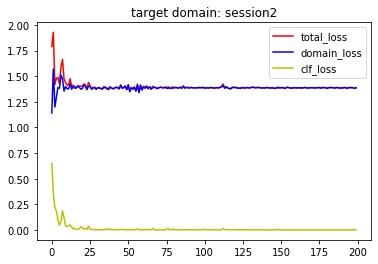

In [8]:
plt.plot(range(len(total_loss)),total_loss,c='r',label='total_loss')
plt.plot(d_loss,c='b',label='domain_loss')
plt.plot(c_loss,c='y',label='clf_loss')
plt.title('target domain: session2')
plt.legend(loc='best')
plt.show()

max target accuracy:  77.8516710160788


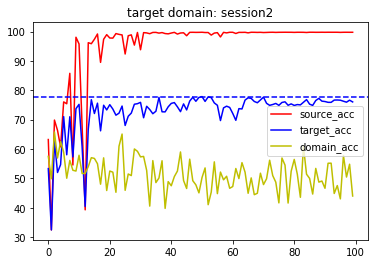

In [9]:
print('max target accuracy: ',max(acc_list2))
plt.plot(range(len(acc_list1)),acc_list1,c='r',label='source_acc')
plt.plot(acc_list2,c='b',label='target_acc')
plt.plot(acc_list3,c='y',label='domain_acc')
plt.axhline(max(acc_list2),c='b',linestyle='--')
plt.title('target domain: session2')
plt.legend(loc='best')
plt.show()